In [1]:
import numpy as np
import random
from numba import njit, prange
from numba import int32, float32, float64    # import the types
from numba.experimental import jitclass
import itertools
from gmpy2 import mpfr, fsum
import gmpy2
import time
import math

import os
import matplotlib.pyplot as plt
import json
from functions import *

In [2]:
%load_ext Cython


In [3]:
%%cython --annotate
# IMPLEMENT TRACE CALCULATIONS IN CYTHON COS NUMBA HAS F'D THINGS UP MULTIPLE TIMES
import numpy as np
cimport cython
cimport numpy as np
from libc.math cimport exp 


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef np.float64_t calc_tr_mult(np.float64_t[:] v, np.float64_t[:, :, :] matrices, np.float64_t[:, :] arr, int[:] lengths):
    cdef np.float64_t s
    s = 0
    
    cdef int base_offset
    base_offset = lengths[0]
    
    cdef np.float64_t h_z
    cdef Py_ssize_t i, j, l, k
    cdef Py_ssize_t arr_x = arr.shape[0]
    cdef Py_ssize_t v_x = v.shape[0]
    cdef Py_ssize_t lengths_x = lengths.shape[0]
#     print(arr_x, v_x, lengths_x)
    for i in range(arr_x):
        h_z = 0
        for j in range(v_x):
            for l in range(lengths[0]):
                h_z += v[j] * matrices[0][j][l] * arr[i][l]
        for k in range(lengths_x - 1):
            for j in range(lengths[k]):
                for l in range(lengths[k+1]):
                    h_z += arr[i][base_offset*k + j] * matrices[k+1][j][l] * arr[i][base_offset*(k+1) + l]
#             cur_index  += lengths[k]
#         print(h_z)
        s += exp(-h_z)
#         if verbose:
#             print(s, h_z)
#     print(s)
    return s

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef np.float64_t[:] calc_tr_mult_v2(np.float64_t[:] v, np.float64_t[:, :, :] matrices, np.float64_t[:, :] arr, int[:] lengths, np.float64_t[:] h_zs):
    cdef int base_offset
    base_offset = lengths[0]
    
    cdef np.float64_t h_z
    cdef Py_ssize_t i, j, l, k
    cdef Py_ssize_t arr_x = arr.shape[0]
    cdef Py_ssize_t v_x = v.shape[0]
    cdef Py_ssize_t lengths_x = lengths.shape[0]
    
    for i in range(arr_x):
        h_z = 0.0
        for j in range(v_x):
            for l in range(lengths[0]):
                h_z += v[j] * matrices[0,j,l] * arr[i][l]
        for k in range(lengths_x - 1):
            for j in range(lengths[k]):
                for l in range(lengths[k+1]):
                    h_z += arr[i, base_offset*k + j] * matrices[k+1,j,l] * arr[i,base_offset*(k+1) + l]
                    
        h_zs[i] = exp(-h_z)
    return h_zs

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef np.float64_t[:] calc_tr_mult_slow(np.float64_t[:] v, np.float64_t[:, :, :] matrices, np.float64_t[:, :] arr, int[:] lengths, np.float64_t[:] h_zs):
    cdef int base_offset
    base_offset = lengths[0]
    
    cdef np.float64_t h_z
    cdef Py_ssize_t i, j, l, k
    cdef Py_ssize_t arr_x = arr.shape[0]
    cdef Py_ssize_t v_x = v.shape[0]
    cdef Py_ssize_t lengths_x = lengths.shape[0]
    
    for i in range(arr_x):
        h_zs[i] = 0
        for j in range(v_x):
            for l in range(lengths[0]):
                h_zs[i] -= v[j] * matrices[0][j,l] * arr[i][l]
        for k in range(lengths_x - 1):
            for j in range(lengths[k]):
                for l in range(lengths[k+1]):
                    h_zs[i] -= arr[i,base_offset*k + j] * matrices[k+1,j,l] * arr[i,base_offset*(k+1) + l]
    return h_zs


In [4]:
# CYTHON VERSION OF MULTILAYER TRACE
def trace_multilayer(matrices, v_init, lengths, v_trains):
    arrs = []
    base_offset = lengths[0]
    if len(v_trains) > 1:
        for v_train in v_trains[1:]:
            seen = set()
            tmp = []
            for item in v_train:
                h_ = "".join([str(x) for x in item])
                if h_ in seen: continue
                seen.add(h_)
                tmp.append(item)
                
            tmp = np.array(tmp)
            b = np.zeros((tmp.shape[0], base_offset))
            b[:, :tmp.shape[1]] = tmp
            arrs.append(b)
#             arrs.append(tmp)
    tmp = np.array(get_confs(lengths[-1]))
    b = np.zeros((tmp.shape[0], base_offset))
    b[:, :tmp.shape[1]] = tmp
    arrs.append(b)
            
    cartesian = itertools.product(*arrs)
    cartesian = [ [item for sublist in x for item in sublist] for x in cartesian]
    cartesian = np.array(cartesian, dtype=np.float64)
    # print(cartesian)
    h_zs = np.array([0] * len(cartesian), dtype=np.float64)
    
    lengths = np.array(lengths, dtype=np.int32)
    res = []
    seen = {}
    first = True
    
    for i in range(len(v_init)):
        # print("{}/{}".format(i+1, len(v_init)))
        hash_ = "".join([str(x) for x in v_init[i]])
        if hash_ not in seen:
            seen[hash_] = calc_tr_mult(v_init[i], matrices, cartesian, lengths)
            if gmpy2.is_inf(seen[hash_]):
                h_zs = np.array(calc_tr_mult_slow(v_init[i], matrices, cartesian, lengths, h_zs))
#                 print(h_zs)
#                 print(max(h_zs))
                seen[hash_] = fsum([gmpy2.exp(item) for item in h_zs])
            # print(seen[hash_])
        res.append(seen[hash_])
    return res


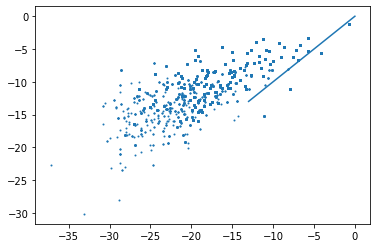

In [7]:
# ITERATE THROUGH DIFFERENT CONFIGURATIONS
from IPython.display import clear_output
# Nvisible = N**2
Nvisible = Nvisible_main = 16

model_ = "ШК"
model_ = "ЭА"

if model_== "ШК":
    J = generate_J(Nvisible, False)
else:
    J = generate_J_NN(Nvisible, False)

train_size = 50000

configurations = {} # List[List[rbm arch, temperature]]

configurations["ШК"] = [
    [[16], 0.4],
    [[16], 2.2],
    [[8, 4, 2], 2],
    [[8, 4, 2], 3],
    [[8, 4, 2], 4],
    [[8, 4, 2], 0.9],
    [[8, 4, 2], 1],
    [[8, 4, 2], 1.1],
    [[8, 4, 2], 1.2],
    [[8, 4, 2], 0.05],
    [[8, 4, 2], 0.1],
    [[8, 4, 2], 0.3],
    [[8, 4, 2], 0.5],
]

configurations["ЭА"] = [
    [[16], 0.2],
    # [[16], 1],
    # [[8, 4, 2], 1],
    # [[8, 4, 2], 2],
    # [[8, 4, 2], 5],
    # [[8, 4, 2], 0.4],
    # [[8, 4, 2], 0.5],
    # [[8, 4, 2], 0.6],
    # [[8, 4, 2], 0.7],
    [[8, 4, 2], 0.05],
    # [[8, 4, 2], 0.1],
    # [[8, 4, 2], 0.3]
]

for conf in configurations[model_]:
    T = conf[1]
    hidden_layers = conf[0]
    
    beta = 1./T
    v_init = generate_train(J, Nvisible_main, train_size, beta, True, False)
    z = calc_Z(J, v_init, beta)
    
    #create model
    model = ML_RBM([Nvisible_main] + conf[0], factor=10)
    model.train(v_init, 300)
    matrices = model.matrices
    
    # transform matrices
    res_matrices = [matrices[0]]
    for i in range(1,len(matrices)):
        tmp = np.zeros(matrices[0].shape)
        for j in range(len(matrices[i])):
            for k in range(len(matrices[i][0])):
                tmp[j,k] = matrices[i][j,k]
        res_matrices.append(tmp)
    matrices = np.array(res_matrices)

    probs_rbm = trace_multilayer(matrices, v_init, hidden_layers, model.train_sets)

    # print(probs_rbm)
    z_rbm = mpfr(0.0)
    probs = []
    seen = set()
    for i in range(len(v_init)):
        h_ = "".join([str(x) for x in v_init[i]])
        if h_ not in seen:
            seen.add(h_)
            z_rbm += probs_rbm[i]
        probs.append([ probs_rbm[i], np.log(P(J, v_init[i], beta, z))])

    for i in range(len(v_init)):
        probs[i][0] = gmpy2.log(probs[i][0] / z_rbm)
    probs = np.array(probs)
    
    filename = "./pics/{}/{}_{}_{}".format(model_, "".join([str(x) for x in conf[0]]), T, train_size)
    np.save(filename, probs)
    
    plt.clf()
    plt.scatter(probs[:, 1], probs[:, 0], 1)
    plt.plot(np.linspace(-13,0,2), np.linspace(-13,0,2))
    plt.savefig("{}.png".format(filename))
    clear_output(wait=True)
